In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import itertools
import random as python_random
from keras.initializers import GlorotUniform
from keras.initializers import Orthogonal
from keras.regularizers import L1L2

np.random.seed(42)
tf.random.set_seed(42)
python_random.seed(42)

In [ ]:
def load_data(filepath):
    return pd.read_csv(filepath, parse_dates=['Date'])

In [ ]:
def create_sequences(data, target, n_steps):
    X, y = [], []
    # print("data", data[:15])
    # print("target", target[:15])
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps)])
        y.append(target[i + n_steps])
    return np.array(X), np.array(y)

In [ ]:
def modify_data(data):
    result = None
    # print(data)

    # copy LMCADY_acu_5d_log into a new column ACU_5D and shift it by 5 days
    data['ACU_5D'] = data['LMCADY_acu_5d_log']
    data['ACU_5D'] = data['ACU_5D'].shift(5)

    data['ACU_4D'] = data['LMCADY'].rolling(window=4).sum()
    data['ACU_3D'] = data['LMCADY'].rolling(window=3).sum()
    data['ACU_2D'] = data['LMCADY'].rolling(window=2).sum()

    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)

    result = data
    # print(result.head(10))
    return result

In [ ]:
def prepare_data(df, target_column, n_steps, feature_list = []):

    df = modify_data(df)
    df.to_csv('./output/modified_data.csv', index=False)

    features = df.drop(columns=[target_column, 'LMCADY_std_5d_log'])
    features = features.drop(columns = ['Date'])
    features = features[feature_list]
    print("Features utilizados:",features.columns)

    target = df[target_column]

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    X, y = create_sequences(features_scaled, target, n_steps)
    # for i in range(15):
    #     print(X[i][0][0], y[i])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle = False)

    return X_train, X_test, y_train, y_test

In [ ]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [ ]:
def build_model(input_shape, md_prm: dict):

    model = Sequential()
    initializer = GlorotUniform(seed=42)
    regularizer = L1L2(l1=0.000005, l2=0.000005)

    model.add(LSTM(md_prm['lstm_units1'], return_sequences=True, input_shape=input_shape, kernel_initializer=initializer, kernel_regularizer=regularizer))
    model.add(LSTM(md_prm['lstm_units2'], kernel_initializer=initializer, kernel_regularizer=regularizer))
    model.add(Dense(1, kernel_initializer=initializer))

    model.compile(optimizer=Adam(learning_rate = 0.0001), loss='mean_squared_error', metrics=[rmse])
    return model

In [ ]:
def train_model(model, X_train, y_train, epochs, batch_size, verbose):

    early_stopping = EarlyStopping(
        monitor             ='val_loss',
        patience            =75,
        verbose             =1,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        epochs              =epochs,
        batch_size          =batch_size,
        verbose             =verbose,
        callbacks           =[early_stopping],
        validation_split    =0.05
    )

    return history

In [ ]:
def evaluate_model(model, X_test, y_test):
    return model.evaluate(X_test, y_test)

In [ ]:
def plot_predictions(y_true, y_pred, n=-1, title="Prediction vs Actual Data", markersize=3, rmse=None):
    if n != -1:
        n = min(n, len(y_true), len(y_pred))

        y_true = y_true[-n:]
        y_pred = y_pred[-n:]

    plt.figure(figsize=(18, 2.5))
    plt.plot(y_true, label='Actual Values', marker='o', linestyle='-', markersize=markersize)

    # Plot the RMSE lines if rmse is provided
    if rmse is not None:
        plt.axhline(y= rmse, color='green', linestyle='--', linewidth=0.7)
        plt.axhline(y=-rmse, color='green', linestyle='--', linewidth=0.7)

        tot_pred = 0
        prof = 0
        loss = 0

        # plot green markers beyond the rmse range
        for i in range(len(y_pred)):
            if (y_pred[i] > rmse or y_pred[i] < - rmse):
                # print("{} {}".format(y_pred[i],y_true[i]))
                if (y_true[i] > 0 and y_pred[i] > 0) or (y_true[i] < 0 and y_pred[i] < 0):
                    plt.plot(i, y_pred[i], 'gx', markersize=markersize+1)
                    prof += 1
                else:
                    plt.plot(i, y_pred[i], 'rx', markersize=markersize+1)
                    loss += 1
                tot_pred += 1
            else:
                plt.plot(i, y_pred[i], marker='x', color='orange', markersize=markersize-1)

    else:
        plt.plot(y_true, label='Actual Values'   , marker='o', linestyle='-' , markersize=markersize)
        plt.plot(y_pred, label='Predicted Values', marker='x', linestyle='--', markersize=markersize)

    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.7)

    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    return tot_pred, prof, loss

In [ ]:
def trend_accuracy(y_true, y_pred):
    trend_up_true = 0
    trend_down_true = 0
    trend_up_pred = 0
    trend_down_pred = 0

    for j in range(len(y_true)-1):
        if y_true[j] > 0.0:
            trend_up_pred += 1
            if y_pred[j] > 0.0:
                trend_up_true += 1
        if y_true[j] < 0.0:
            trend_down_pred += 1
            if y_pred[j] < 0.0:
                trend_down_true += 1

    trend_true = trend_up_true + trend_down_true
    trend_pred = trend_up_pred + trend_down_pred

    trend_up_accuracy = trend_up_true/trend_up_pred
    trend_down_accuracy = trend_down_true/trend_down_pred
    trend_accuracy = trend_true/trend_pred

    return trend_accuracy, trend_up_accuracy, trend_down_accuracy

In [ ]:
n_steps_options     = [60,120]
batch_size_options  = [256,128,64]
epochs_options      = [300]

lstm_units_options1 = [25]
lstm_units_options2 = [25]
activation_options  = ['relu']
dropout_options     = [.15]
num_layers_options  = [2]

# # caso seleccionado
# n_steps_options     = [120]
# batch_size_options  = [256]
# epochs_options      = [300]

# lstm_units_options  = [25]
# activation_options  = ['relu']
# dropout_options     = [.15]
# num_layers_options  = [2]

# variable_options = ['LMCADS03','LMCADY','SPX','MXWD','XAU','XAG','ACU_5D','ACU_4D','ACU_3D','ACU_2D']
# modified_lists = [variable_options[:i] + variable_options[i+1:] for i in range(len(variable_options))]
# print(modified_lists)
modified_lists = [['LMCADS03','LMCADY','SPX','MXWD','XAG','XAU','ACU_5D','ACU_4D','ACU_3D','ACU_2D']]

# combinations
model_params_combinations = list(itertools.product(
    n_steps_options     ,
    lstm_units_options1,
    lstm_units_options2,
    activation_options,
    dropout_options,
    num_layers_options,
    batch_size_options,
    epochs_options,
    modified_lists
))
target_column = 'LMCADY_acu_5d_log'

In [ ]:
n_iterations = len(model_params_combinations)
print("Total iterations: {}".format(n_iterations))

Total iterations: 6


In [ ]:
def run_model_iterations():
    top_results = []
    i = 1
    for params in model_params_combinations:
        n_steps, lstm_units1, lstm_units2, activation, dropout, num_layers, batch_size, epochs, var_options = params
        try:

            # data load
            df = load_data("./input/copper_log_returns_5d_final.csv")
            print("\nIteration {}/{}".format(i, n_iterations))
            print("Params: n_steps: {}, lstm_units1: {}, lstm_units2: {}, activation: {}, dropout: {}, num_layers: {}".format(
                n_steps, lstm_units1, lstm_units2, activation, dropout, num_layers)
            )

            print("Train : batch> {}".format(batch_size))

            # data preparation
            # print("Variables used: {}".format(var_options))
            X_train, X_test, y_train, y_test = prepare_data(df, target_column, n_steps, var_options)

            # build model
            model_params = {
                'lstm_units1': lstm_units1,
                'lstm_units2': lstm_units2,
                'activation': activation,
                'dropout'   : dropout,
                'num_layers': num_layers
            }
            input_shape = (X_train.shape[1], X_train.shape[2])
            print("Input shape: {}".format(input_shape))
            model = build_model(input_shape, model_params)
            print(model.summary())

            # model train
            if True:
                history = train_model(model, X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

                # model evaluation
                y_pred      = model.predict(X_test)
                rmse_score  = math.sqrt(mean_squared_error(y_test, y_pred))
                std_dev     = np.std(y_test)

                print("Pred std dev: {:.6f}, test std dev: {:.6f}".format(np.std(y_pred), std_dev))

                if rmse_score < std_dev:
                    diff = rmse_score - std_dev + abs(np.std(y_pred) - std_dev)/4.0
                else:
                    diff = (rmse_score - std_dev) + abs(np.std(y_pred) - std_dev)/2.0

                # diff = (rmse_score - std_dev) + abs(np.std(y_pred) - std_dev)/2.0
                tren_acc, trend_up, trend_down = trend_accuracy(y_test, y_pred)
                result = {
                    'n_steps'   : n_steps,
                    'lstm_units1': lstm_units1,
                    'lstm_units2': lstm_units2,
                    'activation': activation,
                    'dropout'   : dropout,
                    'num_layers': num_layers,
                    'batch_size': batch_size,
                    'epochs'    : epochs,
                    'rmse'      : rmse_score,
                    'std_dev'   : std_dev,
                    'diff'      : diff,
                    'predictions': y_pred,
                    'true_values': y_test,
                    'feature_list': var_options,
                    'tr_ac': tren_acc,
                    'tr_up': trend_up,
                    'tr_down': trend_down
                }

                # print("RMSE: {:.6f}, STD_DEV: {:.6f}, DIFF: {:.6f}".format(rmse_score, std_dev, diff))
                print("RMSE: {:.6f}, STD_DEV: {:.6f}, STD_PRD: {:.6f}, OBJDIFF: {:.6f}, RDIFF: {:.6f}".format(rmse_score, std_dev, np.std(y_pred), diff, (rmse_score - std_dev)))

                print("Trend: {:.2f}, Up: {:.2f}, Down: {:.2f}".format(tren_acc*100, trend_up*100, trend_down*100))

                top_results.append(result)
                top_results = sorted(top_results, key=lambda x: x['diff'])
                plot_predictions(result['true_values'], result['predictions'], -1, title="It. {}".format(i),rmse = rmse_score)

            print("Completed Iteration {}/{}".format(i, n_iterations))
        except Exception as ex:
            print(f"An error occurred: {ex}. Skipping this combination.")
        i += 1
    return top_results


Iteration 1/6
Params: n_steps: 60, lstm_units1: 25, lstm_units2: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 256
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (60, 10)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 25)            3600      
                                                                 
 lstm_1 (LSTM)               (None, 25)                5100      
                                                                 
 dense (Dense)               (None, 1)                 26        
                                                                 
Total params: 8726 (34.09 KB)
Trainable params: 8726 (34.09 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________________________________

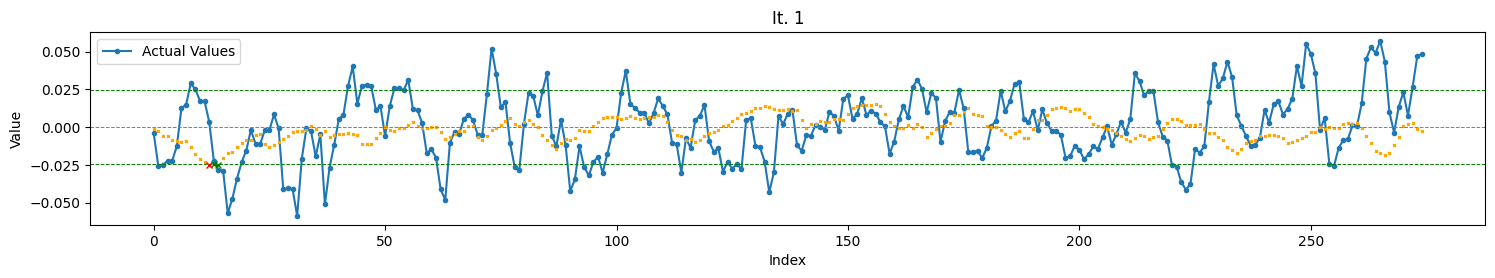

Completed Iteration 1/6

Iteration 2/6
Params: n_steps: 60, lstm_units1: 25, lstm_units2: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 128
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (60, 10)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 25)            3600      
                                                                 
 lstm_3 (LSTM)               (None, 25)                5100      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 8726 (34.09 KB)
Trainable params: 8726 (34.09 KB)
Non-trainable params: 0 (0.00 Byte)
___________________

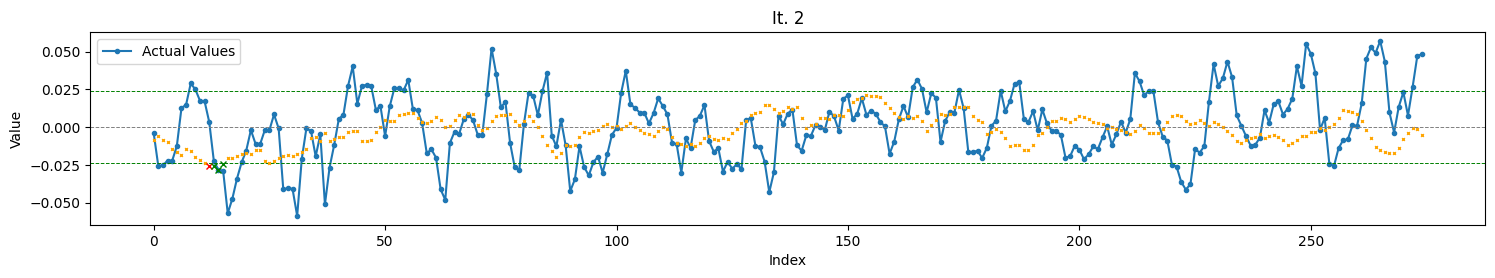

Completed Iteration 2/6

Iteration 3/6
Params: n_steps: 60, lstm_units1: 25, lstm_units2: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 64
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (60, 10)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 25)            3600      
                                                                 
 lstm_5 (LSTM)               (None, 25)                5100      
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 8726 (34.09 KB)
Trainable params: 8726 (34.09 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

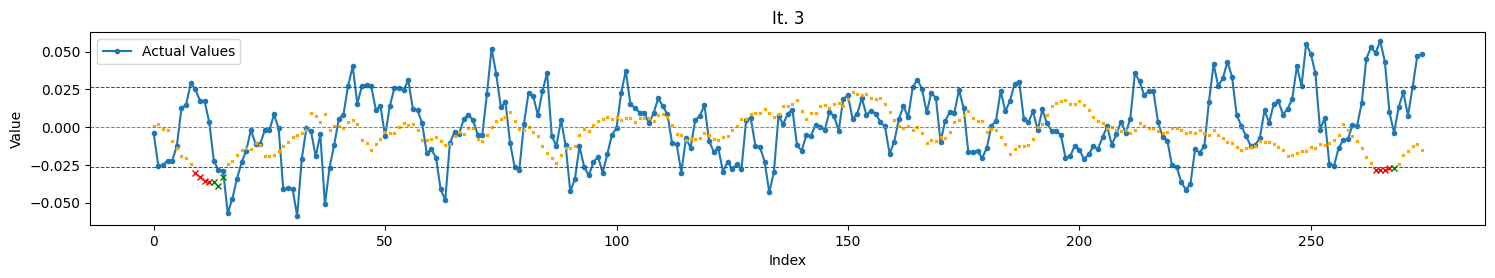

Completed Iteration 3/6

Iteration 4/6
Params: n_steps: 120, lstm_units1: 25, lstm_units2: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 256
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 120, 25)           3600      
                                                                 
 lstm_7 (LSTM)               (None, 25)                5100      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 8726 (34.09 KB)
Trainable params: 8726 (34.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________

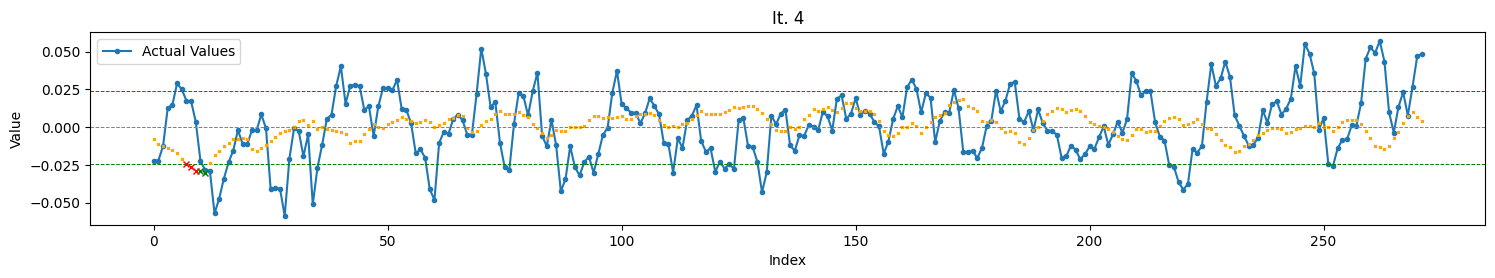

Completed Iteration 4/6

Iteration 5/6
Params: n_steps: 120, lstm_units1: 25, lstm_units2: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 128
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 120, 25)           3600      
                                                                 
 lstm_9 (LSTM)               (None, 25)                5100      
                                                                 
 dense_4 (Dense)             (None, 1)                 26        
                                                                 
Total params: 8726 (34.09 KB)
Trainable params: 8726 (34.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________

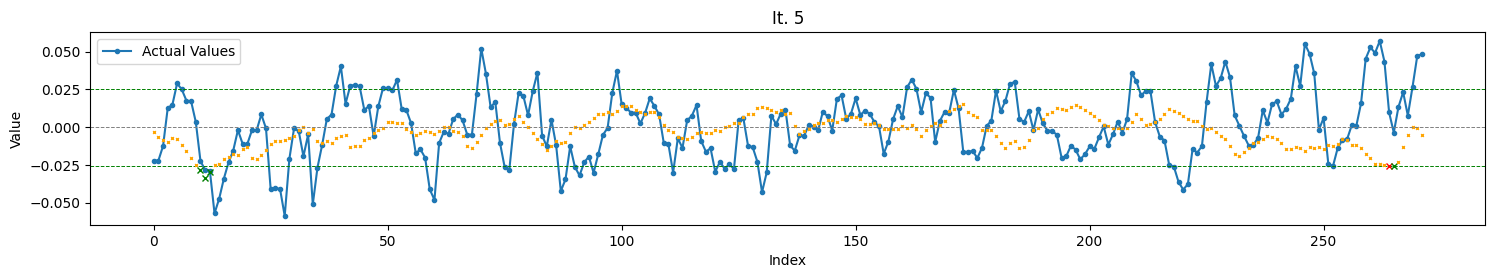

Completed Iteration 5/6

Iteration 6/6
Params: n_steps: 120, lstm_units1: 25, lstm_units2: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 64
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 120, 25)           3600      
                                                                 
 lstm_11 (LSTM)              (None, 25)                5100      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 8726 (34.09 KB)
Trainable params: 8726 (34.09 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

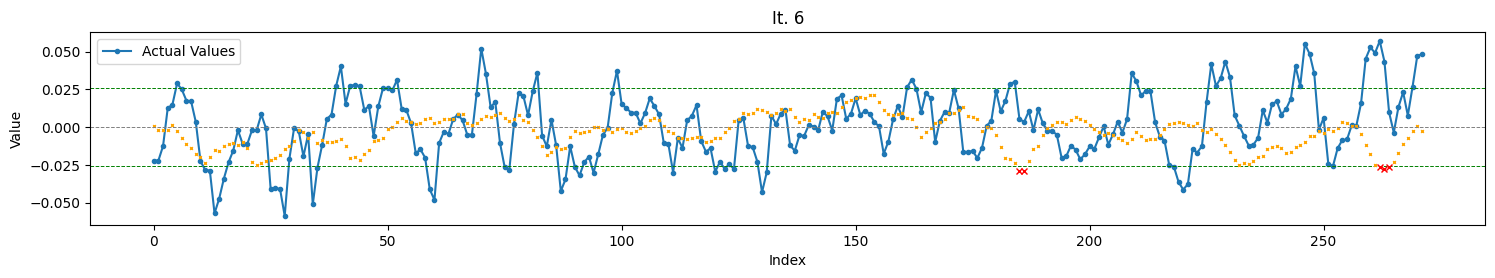

Completed Iteration 6/6


In [ ]:
top_results = run_model_iterations()

In [ ]:
top_results_sort = sorted(top_results, key=lambda x: x['diff'])[:15]

Top 1 - 0.5
RMSE: 0.023690, STD_DEV: 0.022002, STD_PRD: 0.009953, OBJDIFF: 0.007713, RDIFF: 0.001688
n_steps: 60, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 128, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.024159, inv. diff> 0.008182
Trend accuracy       : 48.540
Trend up accuracy    : 45.517
Trend down accuracy  : 51.938


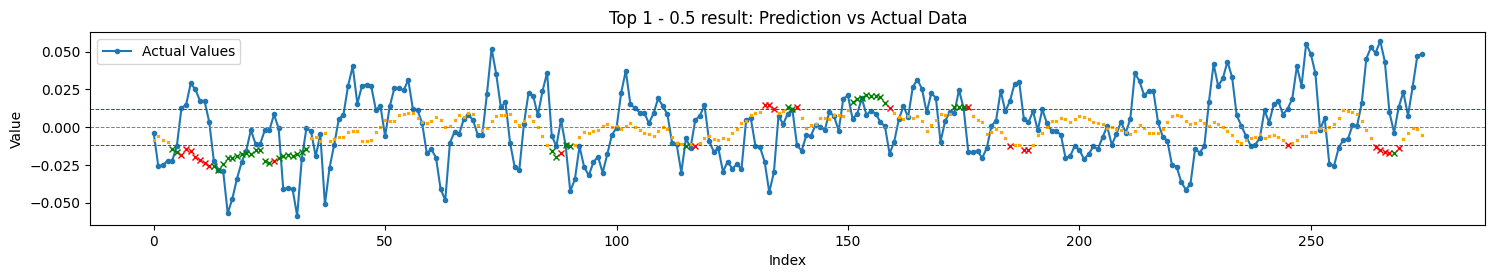

Total TH Pred.: 66
TH Pred. acc. : 62.12


Top 2 - 0.5
RMSE: 0.024200, STD_DEV: 0.022002, STD_PRD: 0.008689, OBJDIFF: 0.008854, RDIFF: 0.002198
n_steps: 120, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 256, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023746, inv. diff> 0.008400
Trend accuracy       : 46.125
Trend up accuracy    : 53.103
Trend down accuracy  : 38.095


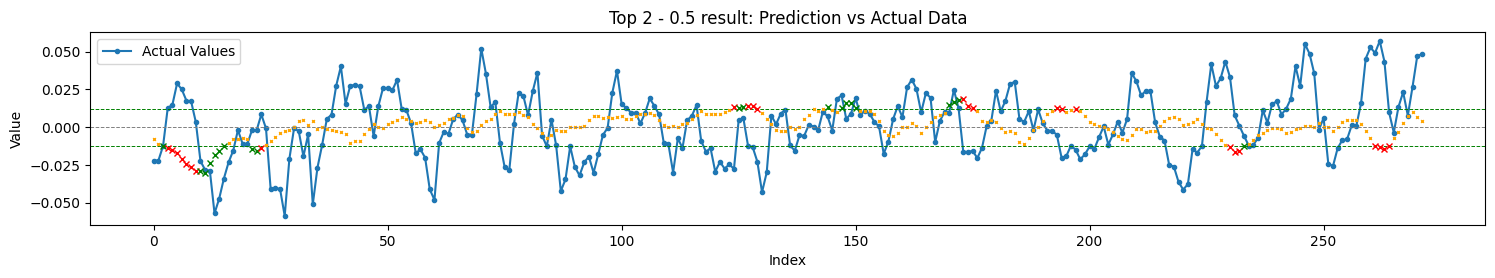

Total TH Pred.: 45
TH Pred. acc. : 44.44


Top 3 - 0.5
RMSE: 0.025342, STD_DEV: 0.022002, STD_PRD: 0.009943, OBJDIFF: 0.009370, RDIFF: 0.003341
n_steps: 120, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 128, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.024202, inv. diff> 0.008230
Trend accuracy       : 48.708
Trend up accuracy    : 39.310
Trend down accuracy  : 59.524


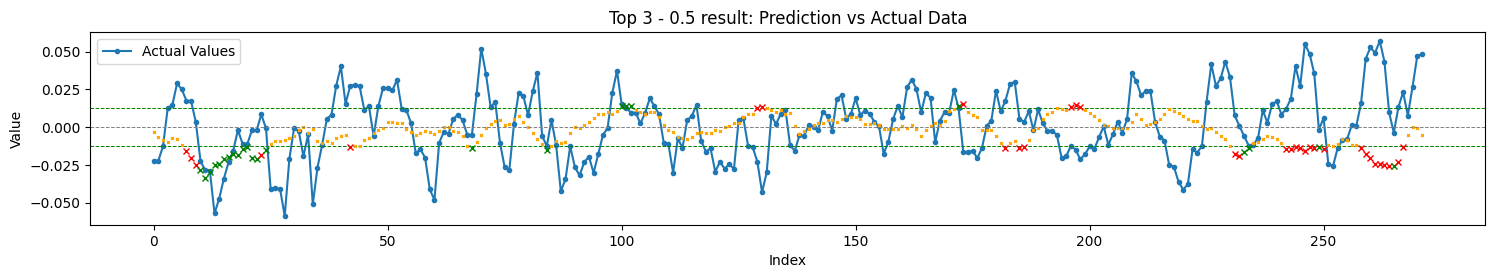

Total TH Pred.: 57
TH Pred. acc. : 42.11


Top 4 - 0.5
RMSE: 0.025700, STD_DEV: 0.022002, STD_PRD: 0.010639, OBJDIFF: 0.009379, RDIFF: 0.003698
n_steps: 120, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 64, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.024537, inv. diff> 0.008217
Trend accuracy       : 46.863
Trend up accuracy    : 37.931
Trend down accuracy  : 57.143


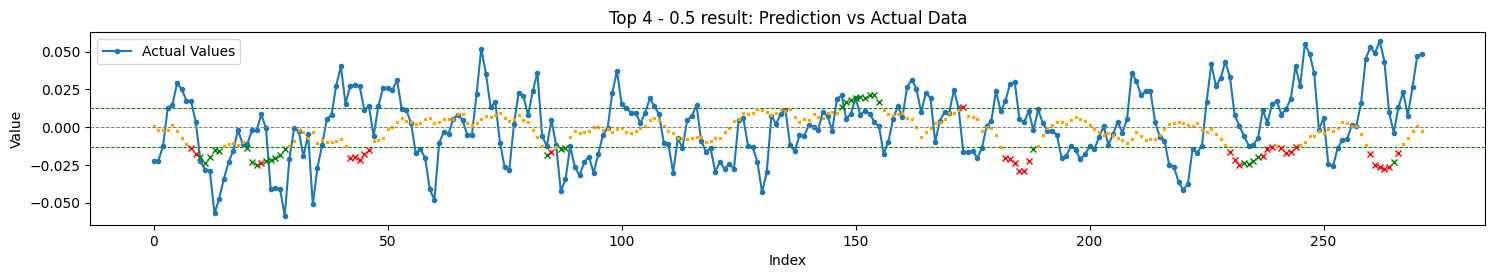

Total TH Pred.: 63
TH Pred. acc. : 49.21


Top 5 - 0.5
RMSE: 0.024421, STD_DEV: 0.022002, STD_PRD: 0.008054, OBJDIFF: 0.009393, RDIFF: 0.002419
n_steps: 60, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 256, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023431, inv. diff> 0.008403
Trend accuracy       : 46.715
Trend up accuracy    : 40.000
Trend down accuracy  : 54.264


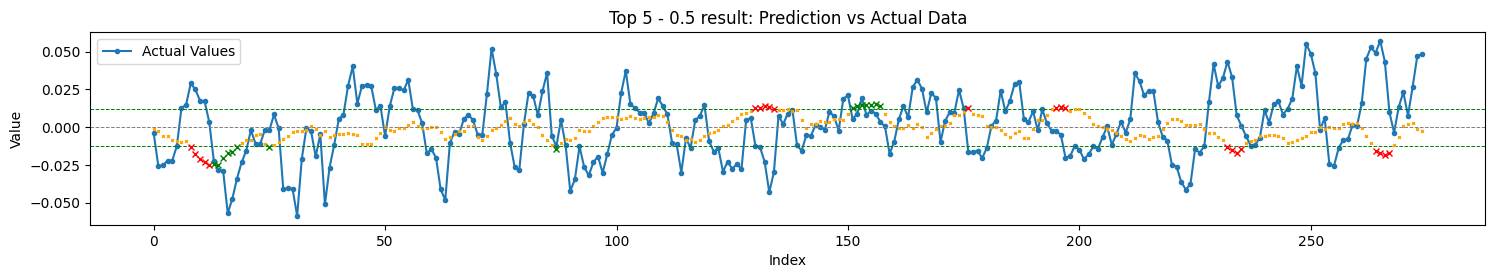

Total TH Pred.: 37
TH Pred. acc. : 40.54


Top 6 - 0.5
RMSE: 0.026582, STD_DEV: 0.022002, STD_PRD: 0.011821, OBJDIFF: 0.009671, RDIFF: 0.004580
n_steps: 60, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 64, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.025087, inv. diff> 0.008176
Trend accuracy       : 47.810
Trend up accuracy    : 35.862
Trend down accuracy  : 61.240


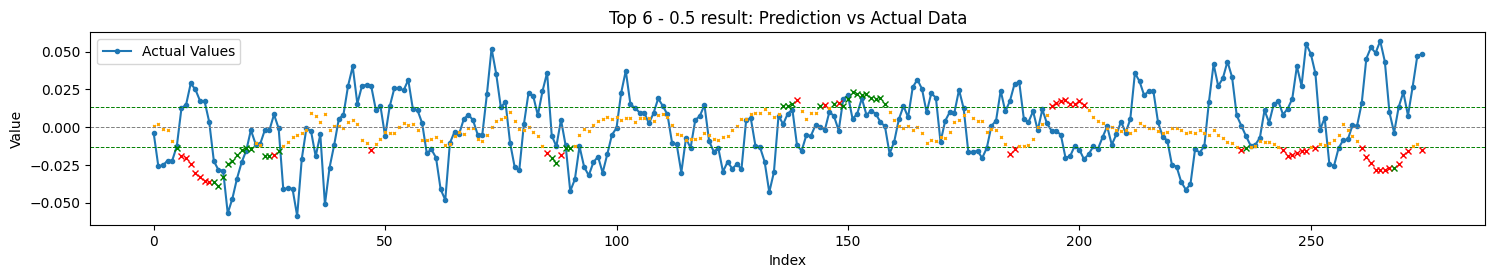

Total TH Pred.: 77
TH Pred. acc. : 44.16


Top 1 - 0.6
RMSE: 0.023690, STD_DEV: 0.022002, STD_PRD: 0.009953, OBJDIFF: 0.007713, RDIFF: 0.001688
n_steps: 60, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 128, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.024159, inv. diff> 0.008182
Trend accuracy       : 48.540
Trend up accuracy    : 45.517
Trend down accuracy  : 51.938


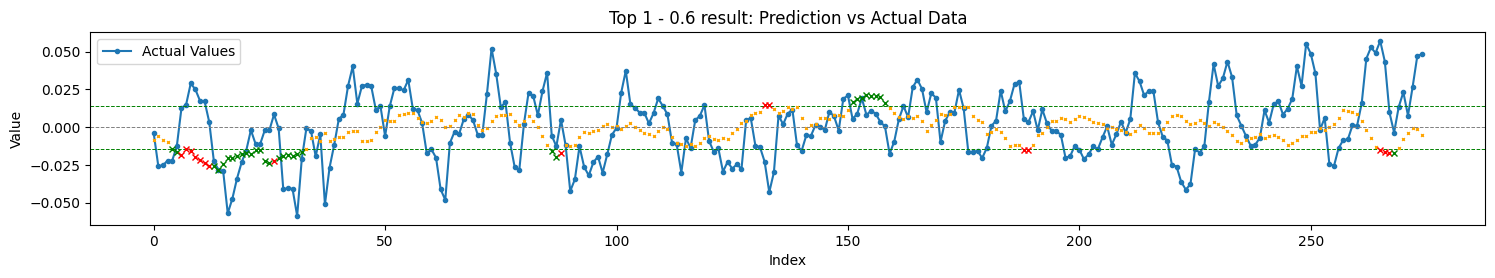

Total TH Pred.: 48
TH Pred. acc. : 66.67


Top 2 - 0.6
RMSE: 0.024200, STD_DEV: 0.022002, STD_PRD: 0.008689, OBJDIFF: 0.008854, RDIFF: 0.002198
n_steps: 120, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 256, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023746, inv. diff> 0.008400
Trend accuracy       : 46.125
Trend up accuracy    : 53.103
Trend down accuracy  : 38.095


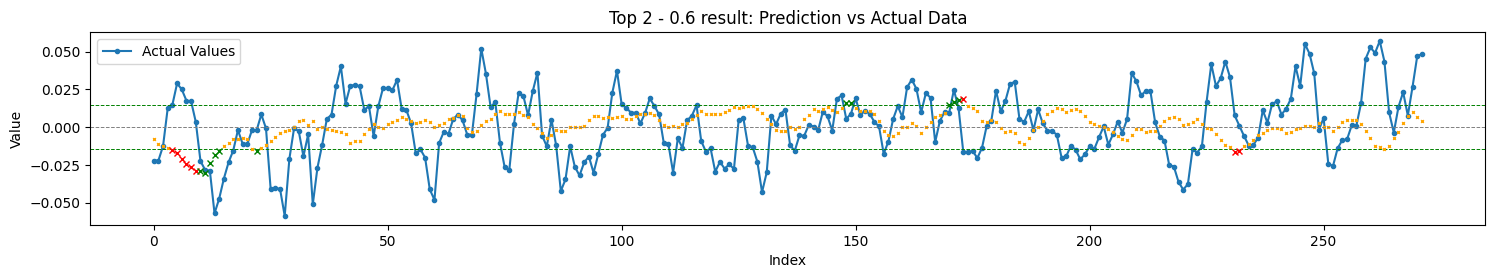

Total TH Pred.: 20
TH Pred. acc. : 55.00


Top 3 - 0.6
RMSE: 0.025342, STD_DEV: 0.022002, STD_PRD: 0.009943, OBJDIFF: 0.009370, RDIFF: 0.003341
n_steps: 120, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 128, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.024202, inv. diff> 0.008230
Trend accuracy       : 48.708
Trend up accuracy    : 39.310
Trend down accuracy  : 59.524


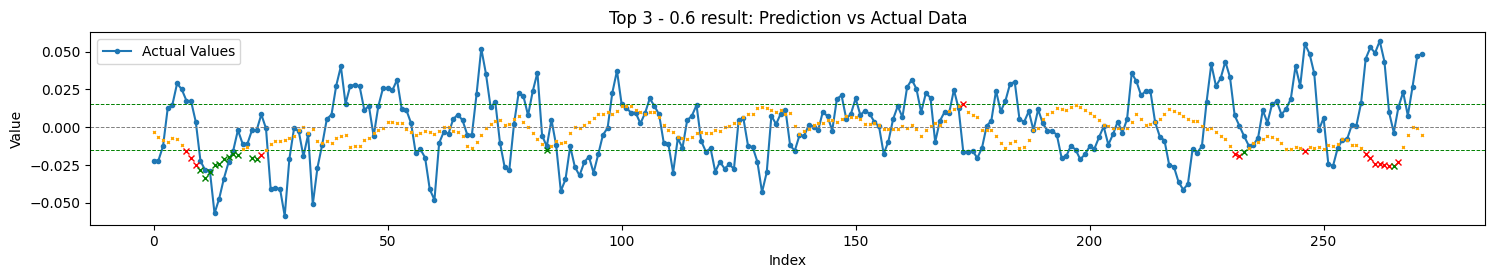

Total TH Pred.: 29
TH Pred. acc. : 48.28


Top 4 - 0.6
RMSE: 0.025700, STD_DEV: 0.022002, STD_PRD: 0.010639, OBJDIFF: 0.009379, RDIFF: 0.003698
n_steps: 120, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 64, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.024537, inv. diff> 0.008217
Trend accuracy       : 46.863
Trend up accuracy    : 37.931
Trend down accuracy  : 57.143


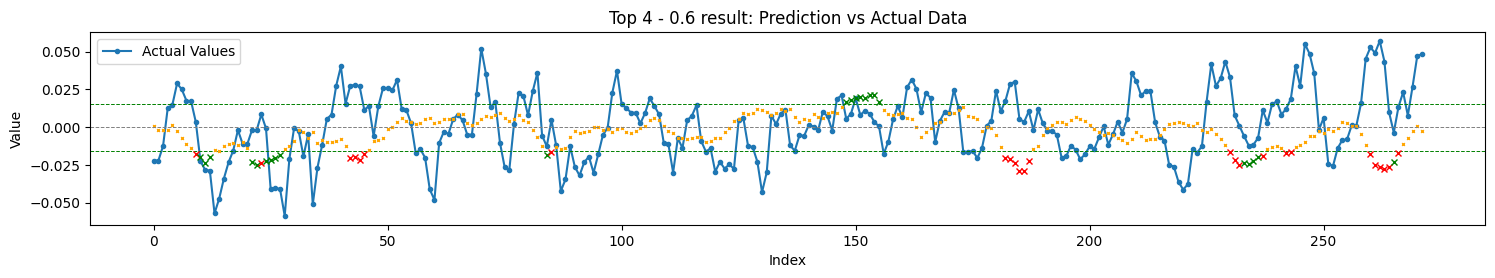

Total TH Pred.: 48
TH Pred. acc. : 47.92


Top 5 - 0.6
RMSE: 0.024421, STD_DEV: 0.022002, STD_PRD: 0.008054, OBJDIFF: 0.009393, RDIFF: 0.002419
n_steps: 60, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 256, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023431, inv. diff> 0.008403
Trend accuracy       : 46.715
Trend up accuracy    : 40.000
Trend down accuracy  : 54.264


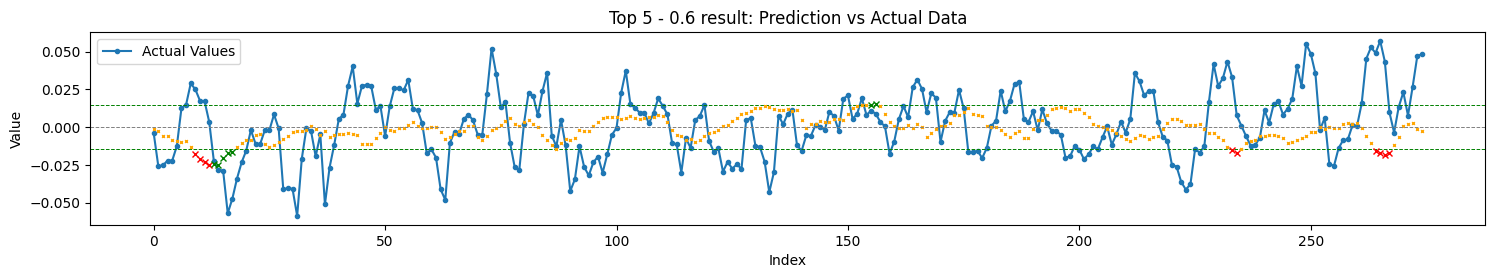

Total TH Pred.: 17
TH Pred. acc. : 41.18


Top 6 - 0.6
RMSE: 0.026582, STD_DEV: 0.022002, STD_PRD: 0.011821, OBJDIFF: 0.009671, RDIFF: 0.004580
n_steps: 60, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 64, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.025087, inv. diff> 0.008176
Trend accuracy       : 47.810
Trend up accuracy    : 35.862
Trend down accuracy  : 61.240


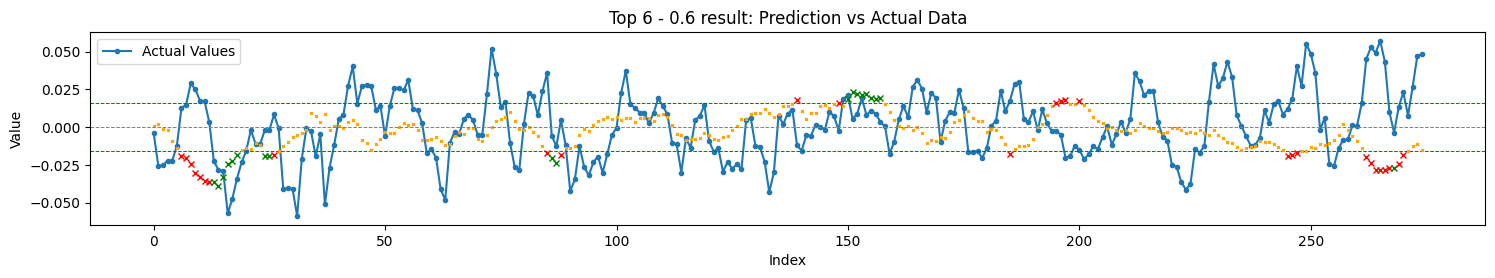

Total TH Pred.: 47
TH Pred. acc. : 40.43


Top 1 - 0.7
RMSE: 0.023690, STD_DEV: 0.022002, STD_PRD: 0.009953, OBJDIFF: 0.007713, RDIFF: 0.001688
n_steps: 60, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 128, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.024159, inv. diff> 0.008182
Trend accuracy       : 48.540
Trend up accuracy    : 45.517
Trend down accuracy  : 51.938


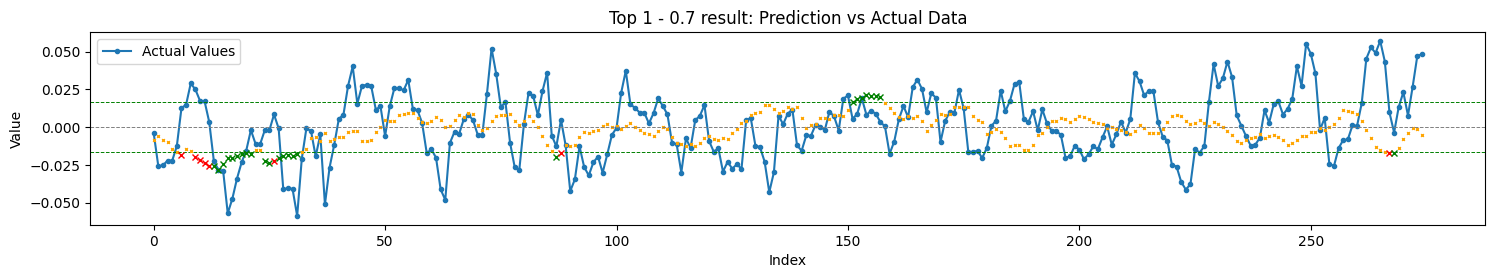

Total TH Pred.: 33
TH Pred. acc. : 75.76


Top 2 - 0.7
RMSE: 0.024200, STD_DEV: 0.022002, STD_PRD: 0.008689, OBJDIFF: 0.008854, RDIFF: 0.002198
n_steps: 120, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 256, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023746, inv. diff> 0.008400
Trend accuracy       : 46.125
Trend up accuracy    : 53.103
Trend down accuracy  : 38.095


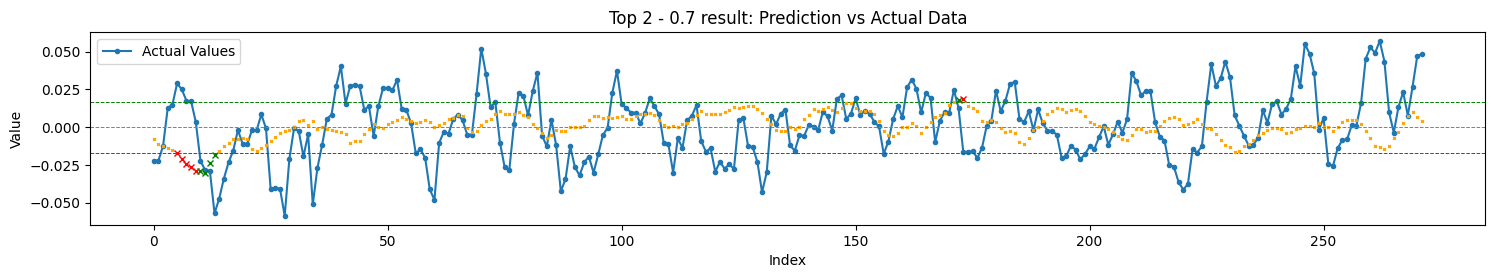

Total TH Pred.: 11
TH Pred. acc. : 45.45


Top 3 - 0.7
RMSE: 0.025342, STD_DEV: 0.022002, STD_PRD: 0.009943, OBJDIFF: 0.009370, RDIFF: 0.003341
n_steps: 120, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 128, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.024202, inv. diff> 0.008230
Trend accuracy       : 48.708
Trend up accuracy    : 39.310
Trend down accuracy  : 59.524


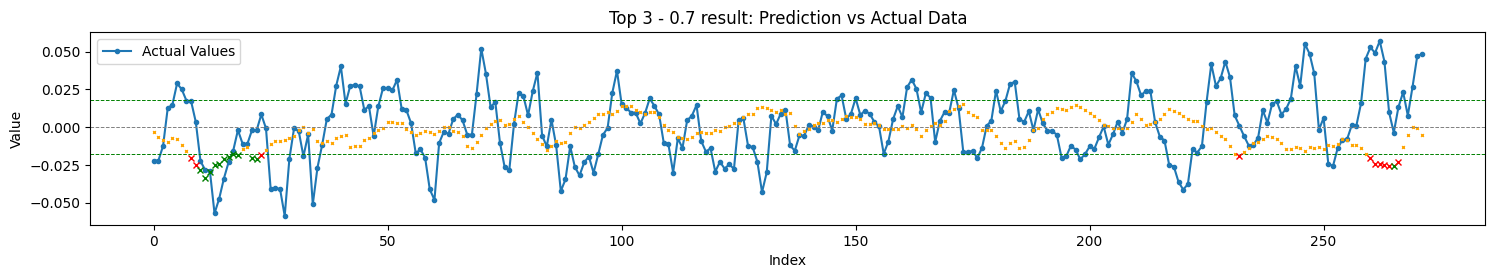

Total TH Pred.: 22
TH Pred. acc. : 54.55


Top 4 - 0.7
RMSE: 0.025700, STD_DEV: 0.022002, STD_PRD: 0.010639, OBJDIFF: 0.009379, RDIFF: 0.003698
n_steps: 120, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 64, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.024537, inv. diff> 0.008217
Trend accuracy       : 46.863
Trend up accuracy    : 37.931
Trend down accuracy  : 57.143


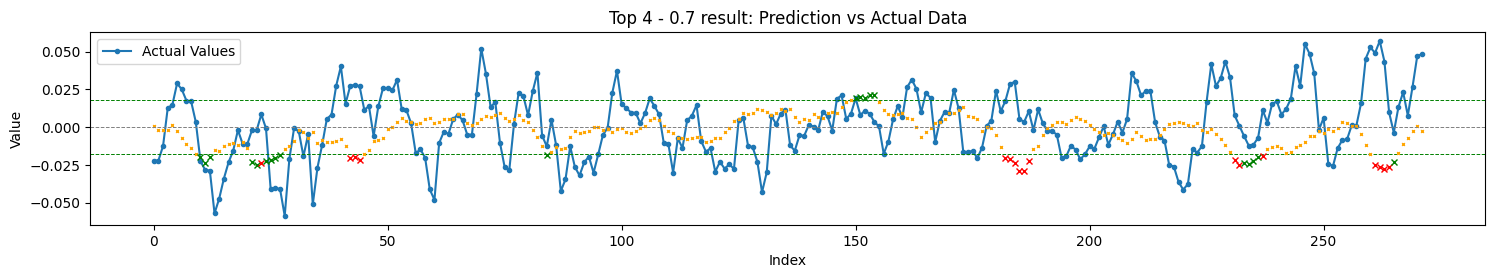

Total TH Pred.: 37
TH Pred. acc. : 54.05


Top 5 - 0.7
RMSE: 0.024421, STD_DEV: 0.022002, STD_PRD: 0.008054, OBJDIFF: 0.009393, RDIFF: 0.002419
n_steps: 60, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 256, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023431, inv. diff> 0.008403
Trend accuracy       : 46.715
Trend up accuracy    : 40.000
Trend down accuracy  : 54.264


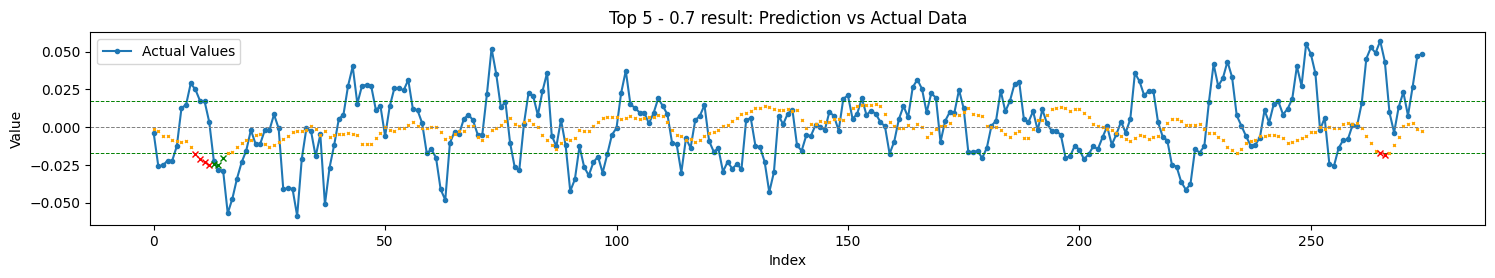

Total TH Pred.: 9
TH Pred. acc. : 33.33


Top 6 - 0.7
RMSE: 0.026582, STD_DEV: 0.022002, STD_PRD: 0.011821, OBJDIFF: 0.009671, RDIFF: 0.004580
n_steps: 60, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 64, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.025087, inv. diff> 0.008176
Trend accuracy       : 47.810
Trend up accuracy    : 35.862
Trend down accuracy  : 61.240


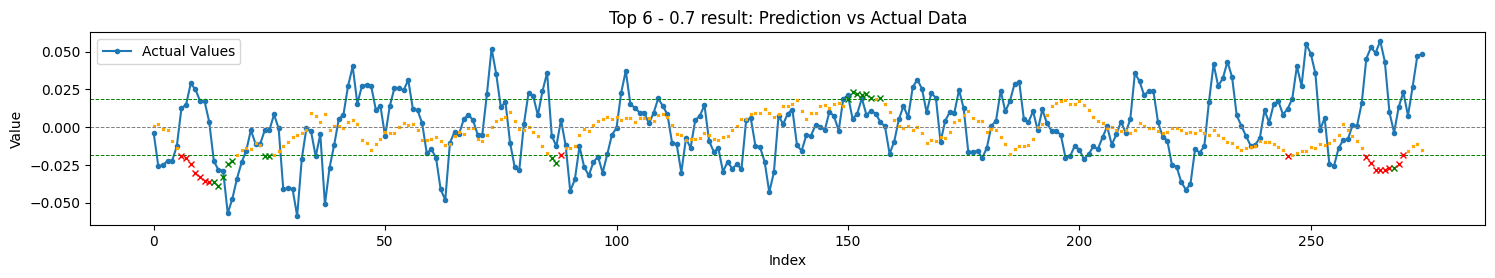

Total TH Pred.: 34
TH Pred. acc. : 50.00


Top 1 - 0.8
RMSE: 0.023690, STD_DEV: 0.022002, STD_PRD: 0.009953, OBJDIFF: 0.007713, RDIFF: 0.001688
n_steps: 60, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 128, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.024159, inv. diff> 0.008182
Trend accuracy       : 48.540
Trend up accuracy    : 45.517
Trend down accuracy  : 51.938


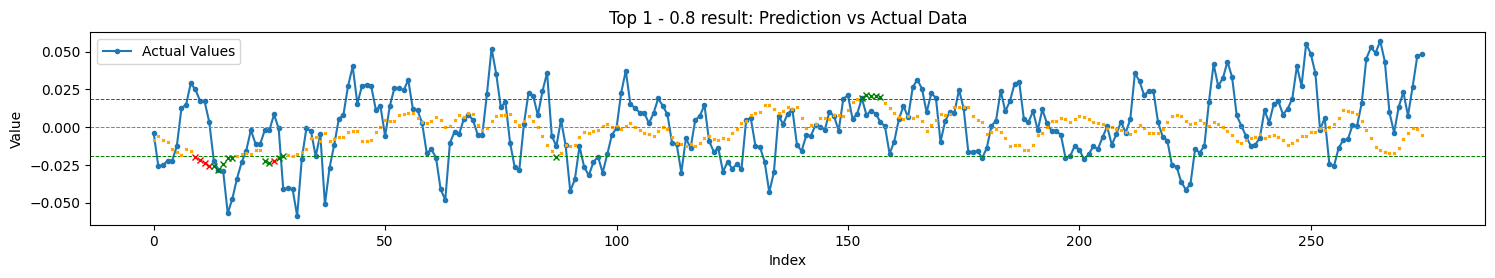

Total TH Pred.: 20
TH Pred. acc. : 75.00


Top 2 - 0.8
RMSE: 0.024200, STD_DEV: 0.022002, STD_PRD: 0.008689, OBJDIFF: 0.008854, RDIFF: 0.002198
n_steps: 120, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 256, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023746, inv. diff> 0.008400
Trend accuracy       : 46.125
Trend up accuracy    : 53.103
Trend down accuracy  : 38.095


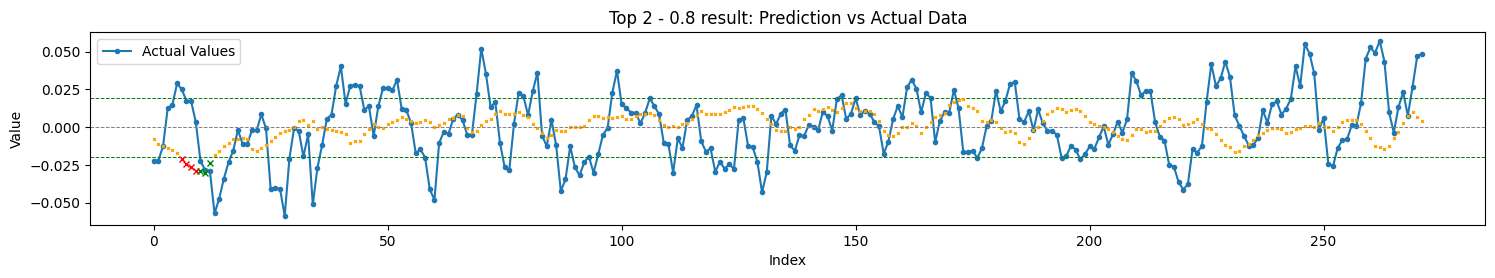

Total TH Pred.: 7
TH Pred. acc. : 42.86


Top 3 - 0.8
RMSE: 0.025342, STD_DEV: 0.022002, STD_PRD: 0.009943, OBJDIFF: 0.009370, RDIFF: 0.003341
n_steps: 120, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 128, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.024202, inv. diff> 0.008230
Trend accuracy       : 48.708
Trend up accuracy    : 39.310
Trend down accuracy  : 59.524


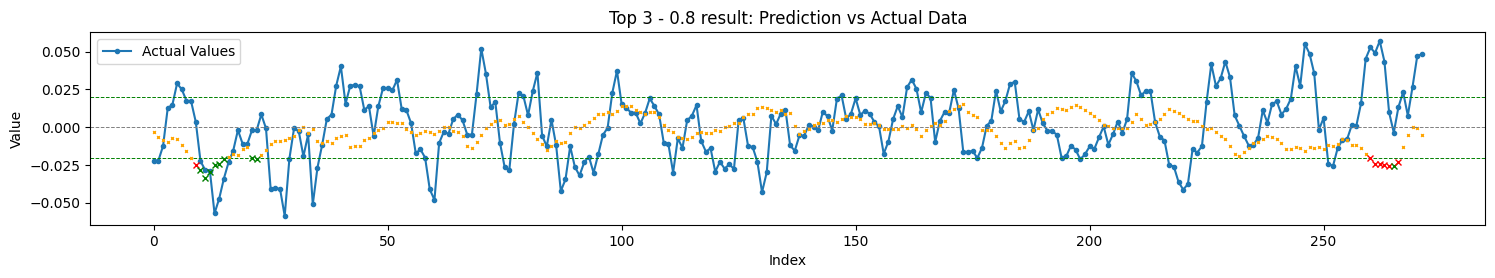

Total TH Pred.: 16
TH Pred. acc. : 56.25


Top 4 - 0.8
RMSE: 0.025700, STD_DEV: 0.022002, STD_PRD: 0.010639, OBJDIFF: 0.009379, RDIFF: 0.003698
n_steps: 120, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 64, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.024537, inv. diff> 0.008217
Trend accuracy       : 46.863
Trend up accuracy    : 37.931
Trend down accuracy  : 57.143


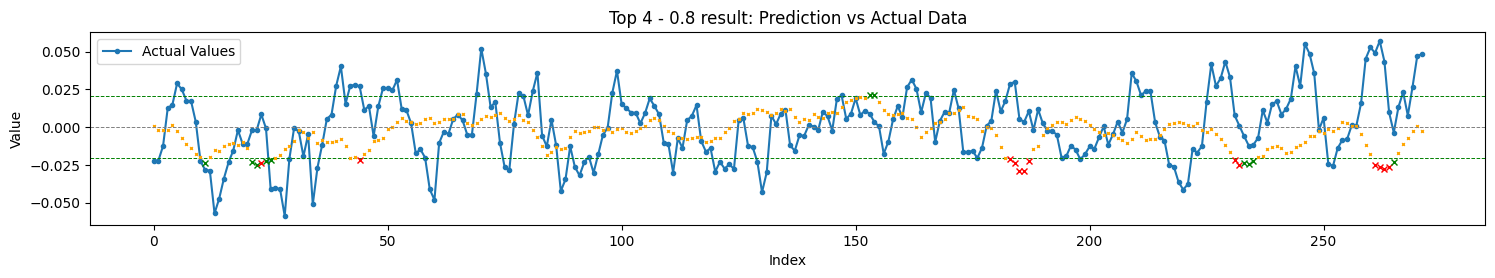

Total TH Pred.: 24
TH Pred. acc. : 45.83


Top 5 - 0.8
RMSE: 0.024421, STD_DEV: 0.022002, STD_PRD: 0.008054, OBJDIFF: 0.009393, RDIFF: 0.002419
n_steps: 60, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 256, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023431, inv. diff> 0.008403
Trend accuracy       : 46.715
Trend up accuracy    : 40.000
Trend down accuracy  : 54.264


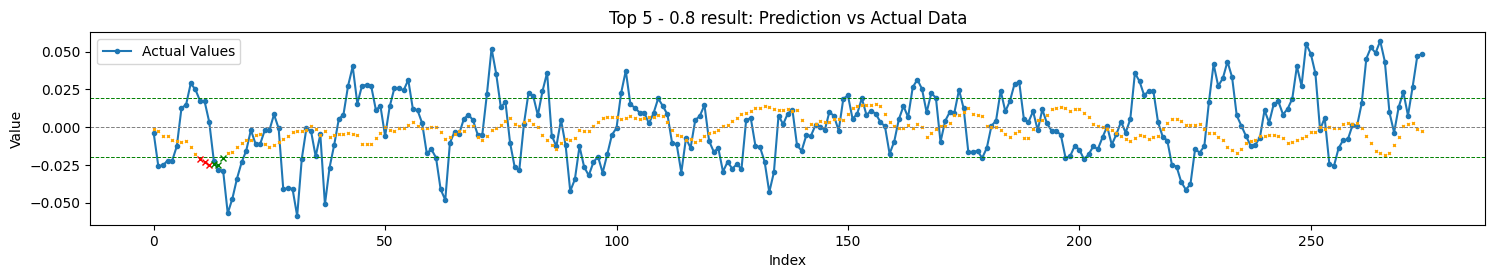

Total TH Pred.: 6
TH Pred. acc. : 50.00


Top 6 - 0.8
RMSE: 0.026582, STD_DEV: 0.022002, STD_PRD: 0.011821, OBJDIFF: 0.009671, RDIFF: 0.004580
n_steps: 60, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 64, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.025087, inv. diff> 0.008176
Trend accuracy       : 47.810
Trend up accuracy    : 35.862
Trend down accuracy  : 61.240


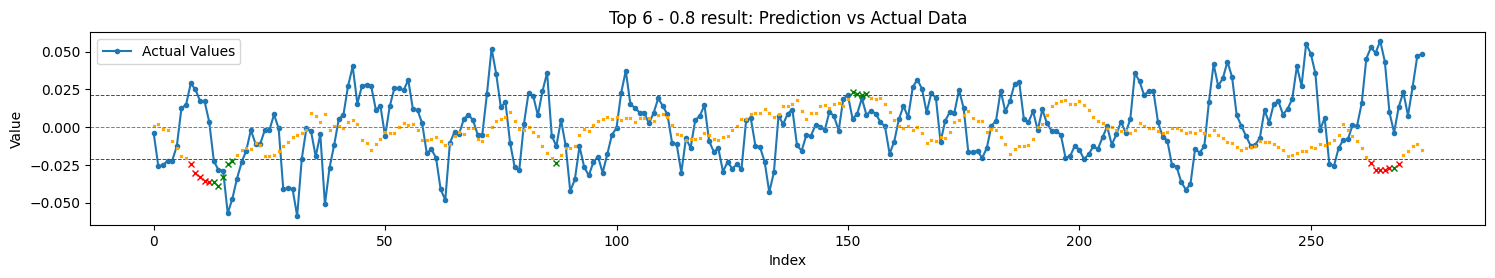

Total TH Pred.: 22
TH Pred. acc. : 50.00


Top 1 - 0.9
RMSE: 0.023690, STD_DEV: 0.022002, STD_PRD: 0.009953, OBJDIFF: 0.007713, RDIFF: 0.001688
n_steps: 60, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 128, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.024159, inv. diff> 0.008182
Trend accuracy       : 48.540
Trend up accuracy    : 45.517
Trend down accuracy  : 51.938


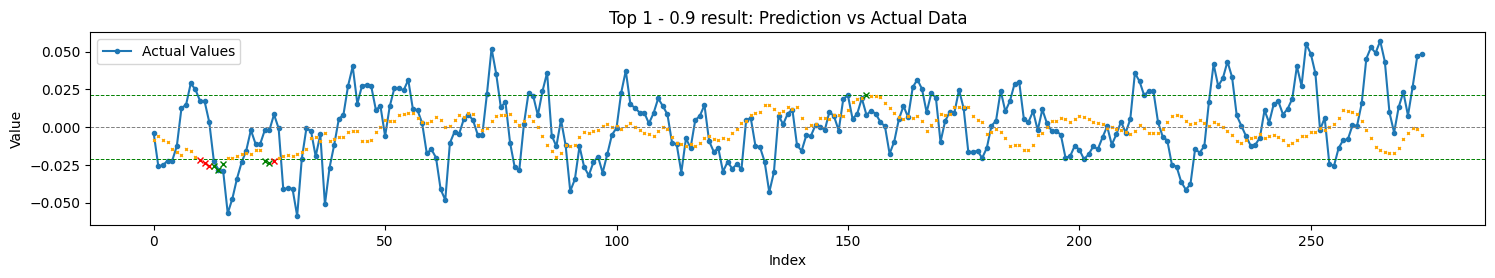

Total TH Pred.: 10
TH Pred. acc. : 60.00


Top 2 - 0.9
RMSE: 0.024200, STD_DEV: 0.022002, STD_PRD: 0.008689, OBJDIFF: 0.008854, RDIFF: 0.002198
n_steps: 120, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 256, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023746, inv. diff> 0.008400
Trend accuracy       : 46.125
Trend up accuracy    : 53.103
Trend down accuracy  : 38.095


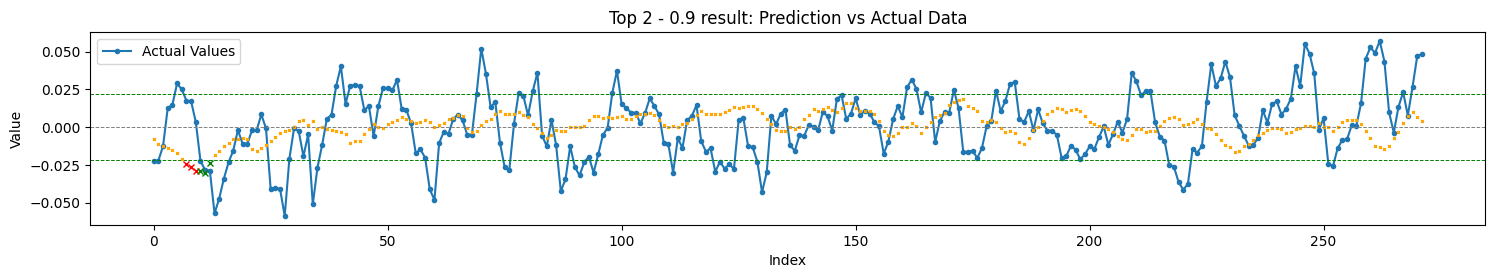

Total TH Pred.: 6
TH Pred. acc. : 50.00


Top 3 - 0.9
RMSE: 0.025342, STD_DEV: 0.022002, STD_PRD: 0.009943, OBJDIFF: 0.009370, RDIFF: 0.003341
n_steps: 120, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 128, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.024202, inv. diff> 0.008230
Trend accuracy       : 48.708
Trend up accuracy    : 39.310
Trend down accuracy  : 59.524


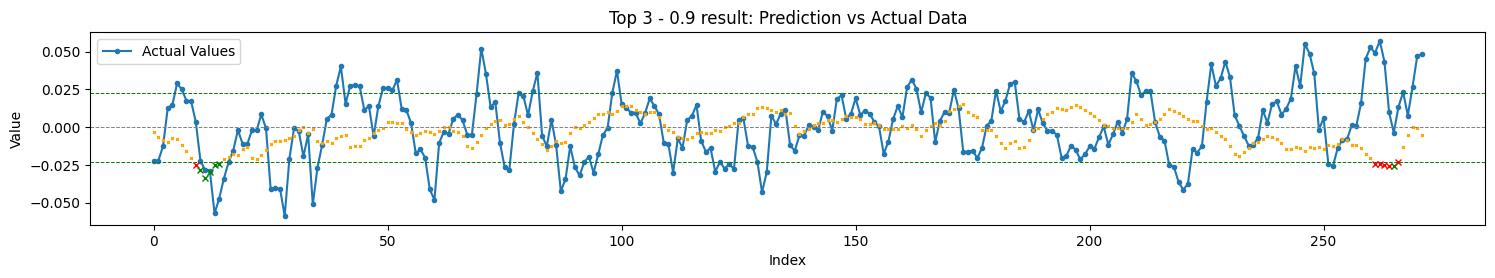

Total TH Pred.: 12
TH Pred. acc. : 50.00


Top 4 - 0.9
RMSE: 0.025700, STD_DEV: 0.022002, STD_PRD: 0.010639, OBJDIFF: 0.009379, RDIFF: 0.003698
n_steps: 120, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 64, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.024537, inv. diff> 0.008217
Trend accuracy       : 46.863
Trend up accuracy    : 37.931
Trend down accuracy  : 57.143


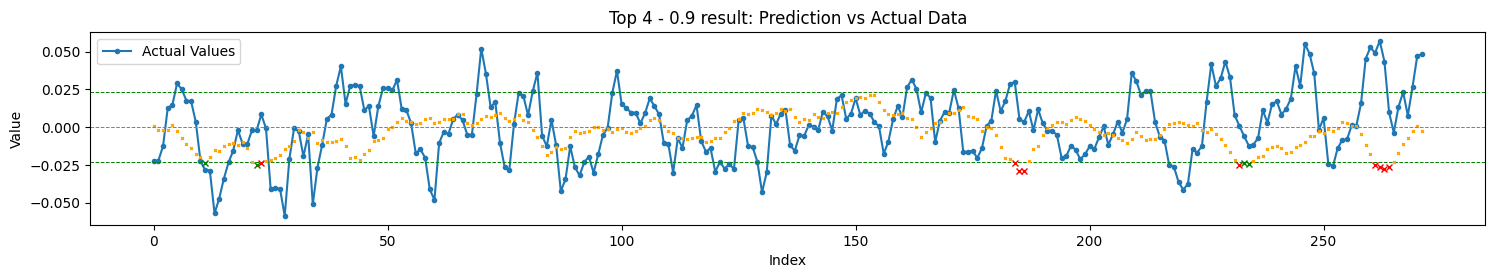

Total TH Pred.: 13
TH Pred. acc. : 30.77


Top 5 - 0.9
RMSE: 0.024421, STD_DEV: 0.022002, STD_PRD: 0.008054, OBJDIFF: 0.009393, RDIFF: 0.002419
n_steps: 60, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 256, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023431, inv. diff> 0.008403
Trend accuracy       : 46.715
Trend up accuracy    : 40.000
Trend down accuracy  : 54.264


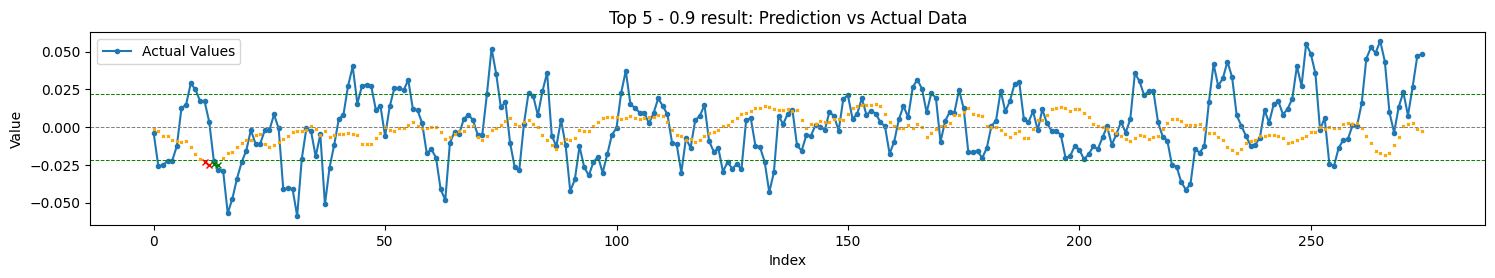

Total TH Pred.: 4
TH Pred. acc. : 50.00


Top 6 - 0.9
RMSE: 0.026582, STD_DEV: 0.022002, STD_PRD: 0.011821, OBJDIFF: 0.009671, RDIFF: 0.004580
n_steps: 60, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 64, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.025087, inv. diff> 0.008176
Trend accuracy       : 47.810
Trend up accuracy    : 35.862
Trend down accuracy  : 61.240


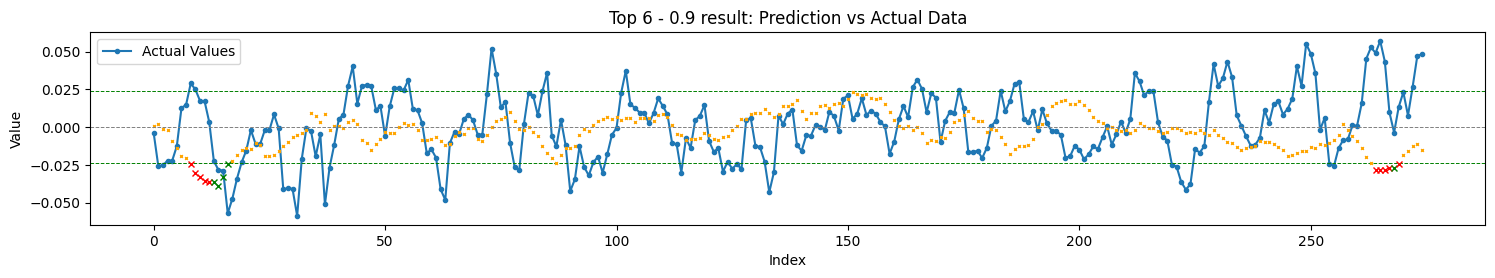

Total TH Pred.: 15
TH Pred. acc. : 33.33


Top 1 - 1.0
RMSE: 0.023690, STD_DEV: 0.022002, STD_PRD: 0.009953, OBJDIFF: 0.007713, RDIFF: 0.001688
n_steps: 60, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 128, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.024159, inv. diff> 0.008182
Trend accuracy       : 48.540
Trend up accuracy    : 45.517
Trend down accuracy  : 51.938


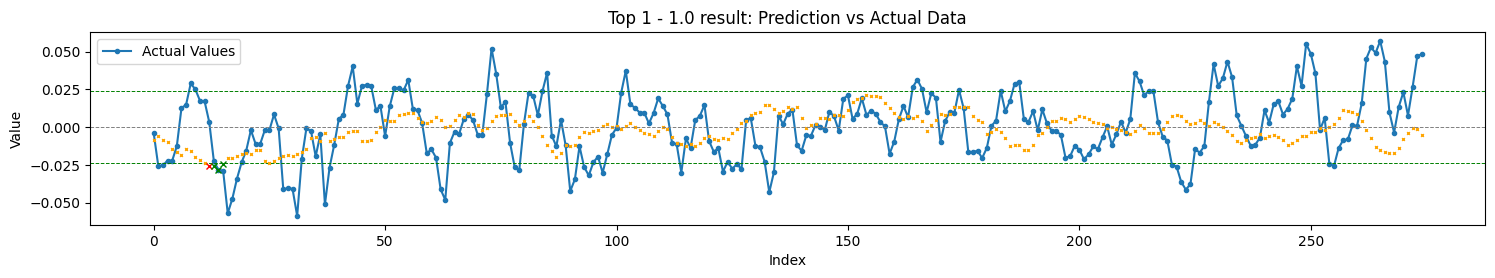

Total TH Pred.: 4
TH Pred. acc. : 75.00


Top 2 - 1.0
RMSE: 0.024200, STD_DEV: 0.022002, STD_PRD: 0.008689, OBJDIFF: 0.008854, RDIFF: 0.002198
n_steps: 120, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 256, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023746, inv. diff> 0.008400
Trend accuracy       : 46.125
Trend up accuracy    : 53.103
Trend down accuracy  : 38.095


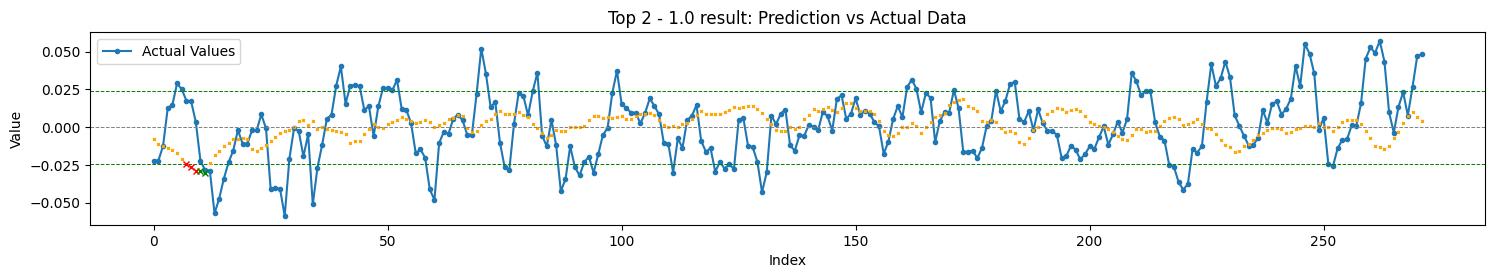

Total TH Pred.: 5
TH Pred. acc. : 40.00


Top 3 - 1.0
RMSE: 0.025342, STD_DEV: 0.022002, STD_PRD: 0.009943, OBJDIFF: 0.009370, RDIFF: 0.003341
n_steps: 120, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 128, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.024202, inv. diff> 0.008230
Trend accuracy       : 48.708
Trend up accuracy    : 39.310
Trend down accuracy  : 59.524


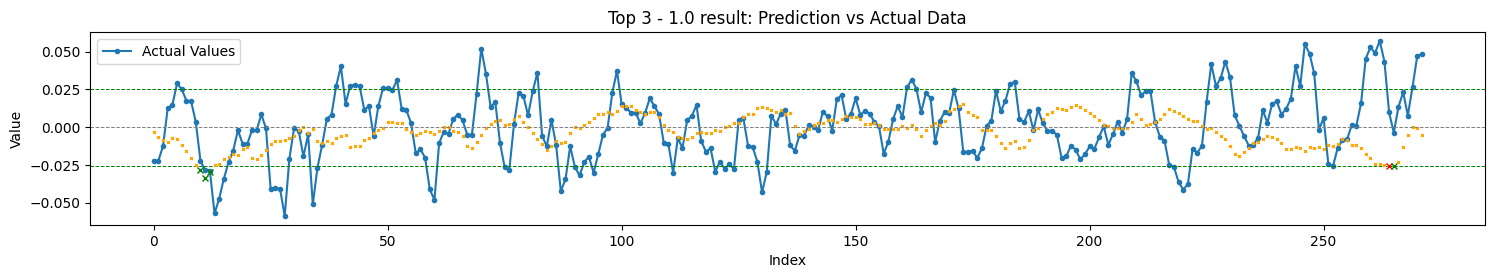

Total TH Pred.: 5
TH Pred. acc. : 80.00


Top 4 - 1.0
RMSE: 0.025700, STD_DEV: 0.022002, STD_PRD: 0.010639, OBJDIFF: 0.009379, RDIFF: 0.003698
n_steps: 120, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 64, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.024537, inv. diff> 0.008217
Trend accuracy       : 46.863
Trend up accuracy    : 37.931
Trend down accuracy  : 57.143


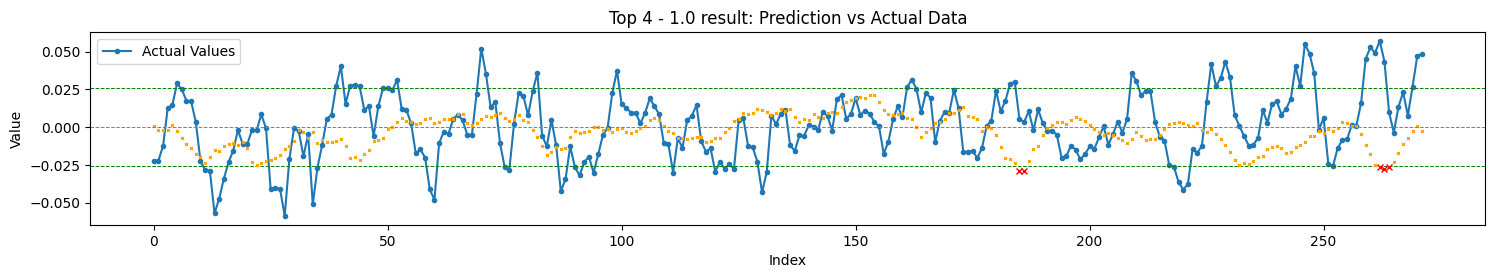

Total TH Pred.: 5
TH Pred. acc. : 0.00


Top 5 - 1.0
RMSE: 0.024421, STD_DEV: 0.022002, STD_PRD: 0.008054, OBJDIFF: 0.009393, RDIFF: 0.002419
n_steps: 60, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 256, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023431, inv. diff> 0.008403
Trend accuracy       : 46.715
Trend up accuracy    : 40.000
Trend down accuracy  : 54.264


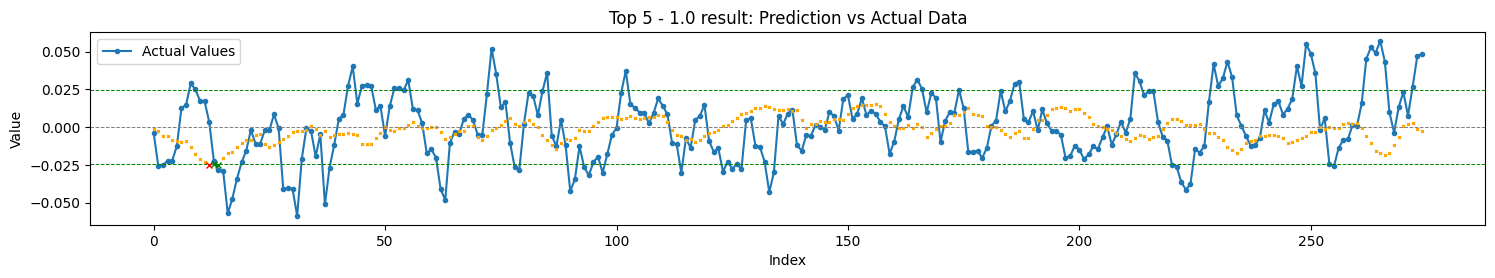

Total TH Pred.: 3
TH Pred. acc. : 66.67


Top 6 - 1.0
RMSE: 0.026582, STD_DEV: 0.022002, STD_PRD: 0.011821, OBJDIFF: 0.009671, RDIFF: 0.004580
n_steps: 60, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 64, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.025087, inv. diff> 0.008176
Trend accuracy       : 47.810
Trend up accuracy    : 35.862
Trend down accuracy  : 61.240


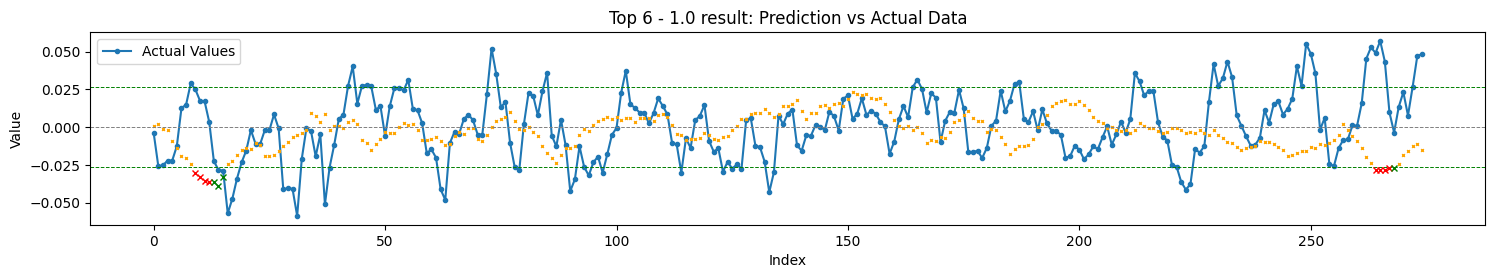

Total TH Pred.: 12
TH Pred. acc. : 33.33




In [ ]:
for mult in [.5,.6,.7,.8,.9,1.0]:
    for i,result in enumerate(top_results_sort,1):

        # if result['rmse']-result['std_dev'] >= 0:
        #     continue

        print(f"Top {i} - {mult}")

        # if (result['rmse']<result['std_dev']):
        #     result['diff'] = result['rmse']-result['std_dev'] + abs(np.std(result['predictions']) - result['std_dev'])/4.0
        # else:
        #     result['diff'] = (result['rmse']- result['std_dev']) + abs(np.std(result['predictions']) - result['std_dev'])/2.0

        print("RMSE: {:.6f}, STD_DEV: {:.6f}, STD_PRD: {:.6f}, OBJDIFF: {:.6f}, RDIFF: {:.6f}".format(result['rmse'], result['std_dev'], np.std(result['predictions']), result['diff'],result['rmse']-result['std_dev']))
        print("n_steps: {}, lstm_u1: {}, lstm_u2: {}, activation: {}, dropout: {}, batch_size: {}, epochs: {}".format(result['n_steps'], result['lstm_units1'], result['lstm_units2'], result['activation'], result['dropout'], result['batch_size'], result['epochs']))
        print("Feature list: ", result['feature_list'])

        # var_tot     = set(variable_options)
        # fea_list    = set(result['feature_list'])
        # print("Discarded var: {}".format(var_tot - fea_list))

        result['inv_rmse'] = inv_rmse = rmse(result['true_values'], result['predictions']*-1)
        inv_diff = (inv_rmse - result['std_dev']) + abs(np.std(result['predictions']) - result['std_dev'])/2.0
        print("Inv. rmse> {:.6f}, inv. diff> {:.6f}".format(inv_rmse, inv_diff))

        # calculate trend prediction percentage

        trend_up_true   = 0
        trend_down_true = 0
        trend_up_pred   = 0
        trend_down_pred = 0

        for j in range(len(result['true_values'])-1):
            if result['true_values'][j] > 0.0:
                trend_up_pred += 1
                if result['predictions'][j] > 0.0:
                    trend_up_true += 1
            if result['true_values'][j] < 0.0:
                trend_down_pred += 1
                if result['predictions'][j] < 0.0:
                    trend_down_true += 1

        trend_true      = trend_up_true + trend_down_true
        trend_pred      = trend_up_pred + trend_down_pred
        trend_accuracy  = trend_true/trend_pred
        print("Trend accuracy       : {:.3f}".format(trend_accuracy*100))
        print("Trend up accuracy    : {:.3f}".format(trend_up_true*100/trend_up_pred))
        print("Trend down accuracy  : {:.3f}".format(trend_down_true*100/trend_down_pred))


        tot_pred, prof, loss = plot_predictions(result['true_values'], result['predictions'],-1, title=f"Top {i} - {mult} result: Prediction vs Actual Data",rmse=result['rmse']*mult)
        print("Total TH Pred.: {}".format(tot_pred))
        if tot_pred != 0:
            print("TH Pred. acc. : {:.2f}".format(prof*100.0/tot_pred))
        print('\n')


In [ ]:
# export the best result predictions and true values to a csv file
best_result = top_results[0]
best_result_df = pd.DataFrame({'True Values': best_result['true_values'], 'Predictions': best_result['predictions'].flatten()})
best_result_df.to_csv('./output/lstm_best_result.csv', index=False)